In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import numpy as np
import os
from src.config import Config
from src.dataset import GraphemeDataset, DataModule

from src.utils import get_parquet_lists, show_batch
from joblib import Parallel, delayed
import swifter

Global seed set to 2021


# Some EDA

In [2]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(Config.data_dir, 'test.csv'))
submission_df = pd.read_csv(os.path.join(Config.data_dir, 'sample_submission.csv'))

In [3]:
train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো
200839,Train_200839,127,2,0,ল্টি


In [4]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
grapheme_root,200840.0,86.415604,44.289815,0.0,53.0,85.0,123.0,167.0
vowel_diacritic,200840.0,3.357757,3.075717,0.0,1.0,2.0,7.0,10.0
consonant_diacritic,200840.0,1.277624,1.872504,0.0,0.0,0.0,2.0,6.0


In [5]:
test_df.tail()

,row_id,image_id,component
31,Test_10_grapheme_root,Test_10,grapheme_root
32,Test_10_vowel_diacritic,Test_10,vowel_diacritic
33,Test_11_consonant_diacritic,Test_11,consonant_diacritic
34,Test_11_grapheme_root,Test_11,grapheme_root
35,Test_11_vowel_diacritic,Test_11,vowel_diacritic


In [6]:
submission_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [7]:
def get_classes_distrib():
    
    vowels_distrib =  pd.DataFrame({
                    'Class' : list(dict(train_df.vowel_diacritic.value_counts()).keys()),
                    'counts' : list(dict(train_df.vowel_diacritic.value_counts()).values())

                })
                    
    grapheme_root_distrib = pd.DataFrame({
                    'Class' : list(dict(train_df.grapheme_root.value_counts()).keys()),
                    'counts' : list(dict(train_df.grapheme_root.value_counts()).values())

                })
    
    consonant_distrib = pd.DataFrame({
                    'Class' : list(dict(train_df.consonant_diacritic.value_counts()).keys()),
                    'counts' : list(dict(train_df.consonant_diacritic.value_counts()).values())

                })
    
    return vowels_distrib, grapheme_root_distrib, consonant_distrib




# Distributions analysis

In [8]:
def plot_distributions():    
    
    """
     Plot the distributions of the target classes
    """
    vowels_distrib, grapheme_root_distrib, consonant_distrib = get_classes_distrib()

    fig , axes = plt.subplots(
        ncols=3, 
        nrows=1, 
        figsize=(23, 5),
        gridspec_kw={
                       'width_ratios': [1, 3, 1],
                       'height_ratios': [1]
                   }
    )
    # vowels distrib
    sb.barplot(data=vowels_distrib, x=vowels_distrib.Class, y=vowels_distrib.counts, ax=axes[0])
    axes[0].set_title('Vowels class distibution ')


    # grapheme root distrib
    sb.barplot(data=grapheme_root_distrib, x=grapheme_root_distrib.Class, y=grapheme_root_distrib.counts, ax=axes[1])
    axes[1].set_title('Grapheme roots class distibution ')
    plt.sca(axes[1])
    plt.xticks(rotation=0, ticks=[x for x in range(168) if x%5==0]) # show each 5 label for readability

    # consonant distrib
    sb.barplot(data=consonant_distrib, x=consonant_distrib.Class, y=consonant_distrib.counts, ax=axes[2])
    axes[2].set_title('consonants class distibution')


    plt.show()
    
    
def get_percentages():
    """
         Get the percentages of majoritary classes in the train dataset
    """
    vowels_distrib, grapheme_root_distrib, consonant_distrib = get_classes_distrib()

    vowel_max_pct = (vowels_distrib['counts'].max() / len(train_df)) * 100
    majoritary_vowel_class = vowels_distrib[vowels_distrib['counts']==vowels_distrib['counts'].max()].Class[0]

    grapheme_root_max_pct = (grapheme_root_distrib['counts'].max() / len(train_df)) * 100
    majoritary_grapheme_root_class = grapheme_root_distrib[grapheme_root_distrib['counts']==grapheme_root_distrib['counts'].max()].Class[0]

    consonants_max_pct = (consonant_distrib['counts'].max() / len(train_df)) * 100
    majoritary_consonant_class = consonant_distrib[consonant_distrib['counts']==consonant_distrib['counts'].max()].Class[0]
    
    print(f'[INFO] Majoritary class in vowels : {majoritary_vowel_class}, \t\t percentage :  {round(vowel_max_pct)}% of the wole dataset')
    print(f'[INFO] Majoritary class in grapheme root: {majoritary_grapheme_root_class}, \t percentage :  {round(grapheme_root_max_pct)}% of the wole dataset')
    print(f'[INFO] Majoritary class in consonant : {majoritary_consonant_class}, \t percentage :  {round(consonants_max_pct)}% of the wole dataset')

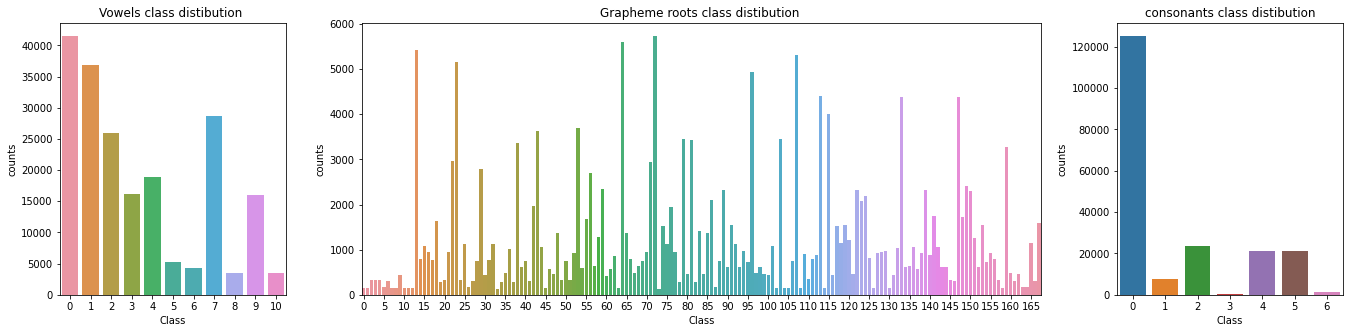

In [9]:
plot_distributions()

## Conslusion 
Obviously we conclude that we have a 3X imbalance datasets probleme to solve.


In [10]:
get_percentages()

[INFO] Majoritary class in vowels : 0, 		 percentage :  21% of the wole dataset
[INFO] Majoritary class in grapheme root: 72, 	 percentage :  3% of the wole dataset
[INFO] Majoritary class in consonant : 0, 	 percentage :  62% of the wole dataset


# show some samples

dm = DataModule(
    df=train_df, 
    frac=1, 
    validation_split=.2, 
    train_batch_size=Config.train_batch_size, 
    test_batch_size=Config.test_batch_size
)

dm.setup()

[INFO] Training on 160672 samples
[INFO] Validating on 40168 samples


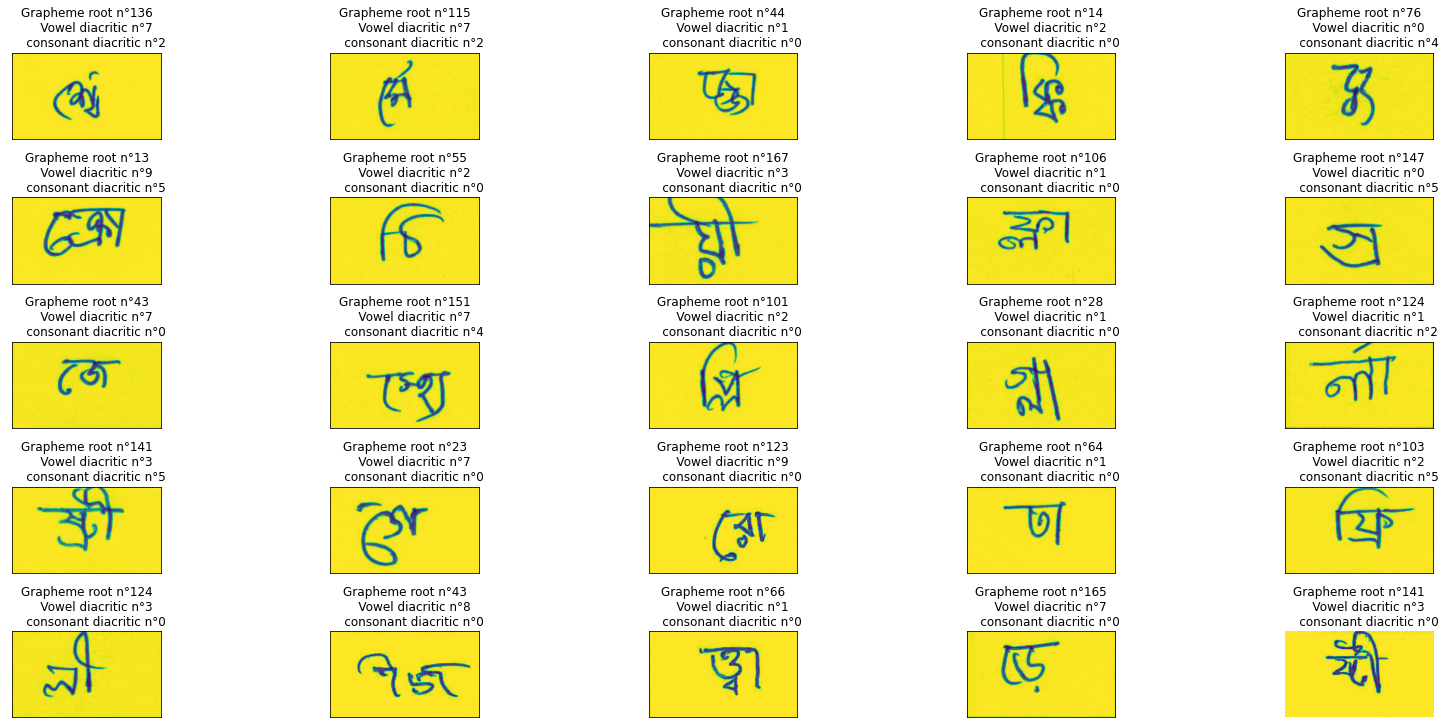

In [11]:
show_batch(subset='train', df=train_df)